<table>
  <tr>
      <td><div style="white-space: pre-wrap;" align="left"><font size="30" >Tutorial B2&#10;EKF </font></div></td>
     <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Spatial_Awareness/Tutorial_B2_Robot_Localisation/image/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

# Set up the session

In [2]:
import os
import math
import numpy as np
import pickle
from importlib import import_module

!git clone https://github.com/Tobias-Fischer/RVSS2022.git
os.chdir('RVSS2022/Spatial_Awareness/Tutorial_B2_Robot_Localisation')

#Visualizer
from Render import *
#Here we import Robot class definition form the other notebook
from EKF_Robot import *
#Here we import a class that defines out measurments
from Measurements import *
#This implements the EKF
import EKF

Cloning into 'RVSS2022'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (425/425), done.
remote: Total 532 (delta 280), reused 302 (delta 99), pack-reused 0
Receiving objects: 100% (532/532), 35.61 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (280/280), done.


## Download groud truth and measurement data and show dead reckoning
The visualiser shows:
- where the robot really is (dark red and green)
- where the robot thinks it is using wheel odometry (light red and green)
- where the robot thinks the landmarks are (light blue lines)

Note that:
- the landmark measurements are uncertain so the endpoints of the lines dance around
- the robot's belief about the positions of the landmarks diverges from the truth over time because its belief about its position diverges also


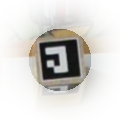
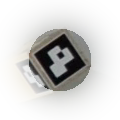
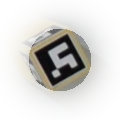
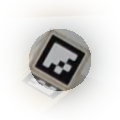
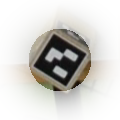
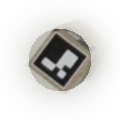
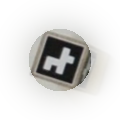
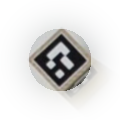
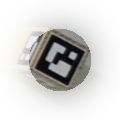
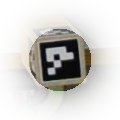

In [3]:
#Here we load our data including the true state 
with open('data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']

#Create a robot and place it at the true starting position and orientation 
bot = EKF_Robot(0.14, 0.01)
#Place the robot at -2.8,-2.8 which is bottom middle of our arena
bot.state = gt_state[0,:].copy().reshape(-1,1)

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))


for c in range(control.shape[0]):
    state[c,:] = bot.state[:,0]
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt)
    bot.drive(drive_signal)

#Create a visualizer and visualize our atate
Render(state=state, gt_state=gt_state, measurements=measurements)

# Now run EKF
Here we suppose that the robot knows the true positions of the landmarks
so it can correct its estimate of its position from the landmark measurements using an Extended Kalman Filter.

Here the visualisation also shows the uncertainty ellipse for its estimate of the robot's position. Note that we are not showing the uncertainty in rotation.


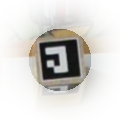
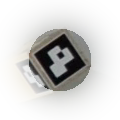
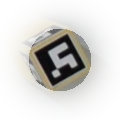
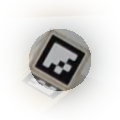
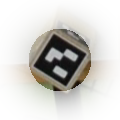
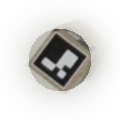
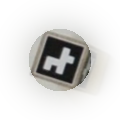
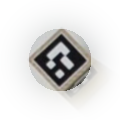
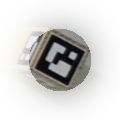
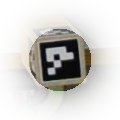

In [5]:
#Here we load our data including the true state 
with open('data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)
    
gt_state = data['state']
control = data['control']
measurements = data['measurement']

#Here are our true marker positions
markers = data['markers']

#Now lets see how well slam does

#Create a robot and place it at the true starting position and orientation 
bot = EKF_Robot(0.15, 0.01)

#Place the robot at -2.8,-2.8 which is bottom middle of our arena
#by copying the initial ground truth position into the estimated state
bot.state = gt_state[0,:].copy().reshape(-1,1)
ekf = EKF.RobotEKF(bot,markers)

# (Big) Initial incertainty of our robot
ekf.P = np.eye(3)*100

#Uncertainty in our left and right wheel motors
sigma_drive = np.array([2,2])

#Uncertainty in measurement
sigma_measure = np.eye(2)

#Apply our control to the robot and visualize
#Our timestamp is always 0.2
dt = 0.2
#Here we will save our state variable 
state = np.zeros((control.shape[0],3))

#Here we save the robot covariances
robot_cov = np.zeros(((control.shape[0],3,3)))

for c in range(control.shape[0]):
    #Set the measurement covariances
    for mes in measurements[c]:
        mes.covariance = sigma_measure 
    drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    ekf.predict(drive_signal)
    ekf.update(measurements[c])
    state[c,:] = bot.state[:,0]
    #drive_signal = DriveMeasurement(control[c,0],control[c,1],dt,sigma_drive[0],sigma_drive[1])
    # Drive and predict
    robot_cov[c,:,:] = ekf.P[0:3,0:3]
    
#Create a visualizer and visualize our state
Render(state=state, gt_state=gt_state, measurements=measurements, robot_cov=robot_cov)
